# Hotspot analysis and gridding

In this notebook we perform a hotspot analysis and show how the polygon data could be transformed into smaller grid cells. 

In [44]:
# Import necessary libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geopy.distance import distance
from esda.getisord import G_Local
from libpysal.weights import DistanceBand, Queen
from splot.libpysal import plot_spatial_weights
import numpy as np
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, spearmanr
from geopy.distance import great_circle
from shapely.geometry import Point, Polygon
import libpysal



## Load Data

In [34]:
##  ---------- Read Shapefile Hamburg  ----------- ##

# Read Hamburg shapefile V2 - This is the correct version Gicela created
hamburg_shp = gpd.read_file("Data/Shapefile_Final")

# Set index to stadtteil 
hamburg_shp.set_index('stadtteil', inplace=True)

# Drop Neuwerk
hamburg_shp.drop("Neuwerk", axis=0, inplace=True)

In [35]:
##  ---------- Read Data ----------- ##

# Refer to Excel for more details
data_df = pd.read_csv('Data/final_data.csv', sep=',')

# Rename first column and drop empty last column
data_df.rename(columns={"Unnamed: 0": "Stadtteil"} ,inplace=True)

# Drop column and set index
data_df.set_index("Stadtteil", inplace=True)

In [36]:
##  ---------- Merge Data ----------- ##

hamburg_shp = pd.merge(hamburg_shp , data_df, left_index=True, right_index=True)

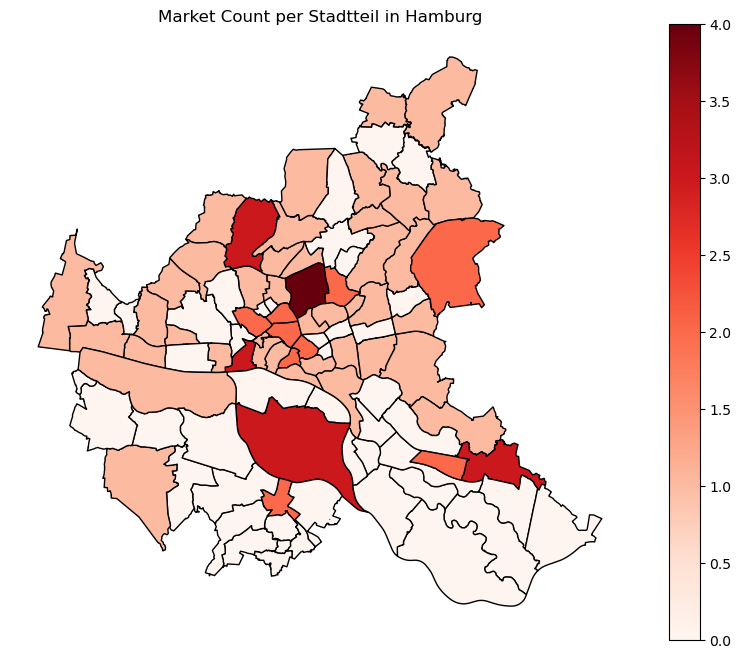

In [37]:
##  ---------- Market Count plot ----------- ##

fig, ax = plt.subplots(figsize=(10, 8))

im = hamburg_shp.plot(
    column='market_count',
    ax=ax,
    edgecolor="k",
    cmap="Reds",
    legend=True, 
)

# remove the axis - I think it looks better 
ax.axis("off")

#Title
ax.set_title("Market Count per Stadtteil in Hamburg")

plt.show()

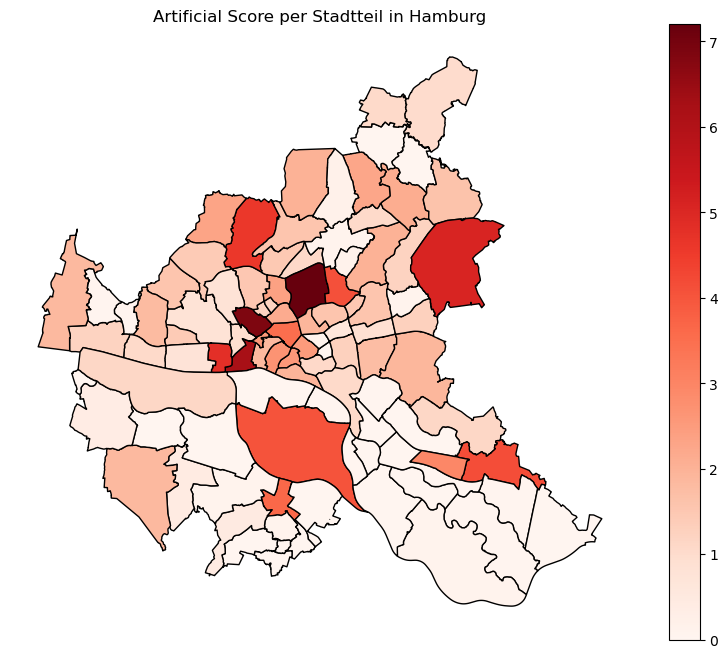

In [38]:
##  ---------- Artificial Score plot ----------- ##

fig, ax = plt.subplots(figsize=(10, 8))

im = hamburg_shp.plot(
    column='art_score',
    ax=ax,
    edgecolor="k",
    cmap="Reds",
    legend=True, 
)

# remove the axis - I think it looks better 
ax.axis("off")

#Title
ax.set_title("Artificial Score per Stadtteil in Hamburg")

plt.show()

## Polygon to Grid

In [39]:
##  ---------- Adjustable Grid  ----------- ##


# Get the bounding box coordinates of the Hamburg shapefile
minx, miny, maxx, maxy = hamburg_shp.total_bounds
print(minx, miny, maxx, maxy)

# Define your grid cell size
grid_width = 0.02  # Adjust this value based on your needs
grid_height = grid_width / 1.7  # Adjusted for square cells

# Generate the grid cell coordinates using numpy's arange
x_coords = np.arange(minx, maxx + grid_width, grid_width)
y_coords = np.arange(miny, maxy + grid_height, grid_height)

print(len(y_coords))
print(len(x_coords))

# Function to calculate the cell size in kilometers
def calc_cell_size():
    # Define points to measure distances
    y1 = Point(9.73013086281067, 53.39501085500329)
    y2 = Point(9.73013086281067, 53.73943731233777)
    x1 = Point(9.73013086281067, 53.39501085500329)
    x2 = Point(10.325276801117477, 53.39501085500329)

    # Calculate the distances in kilometers
    distance_y = great_circle((y1.y, y1.x), (y2.y, y2.x)).kilometers
    distance_x = great_circle((x1.y, x1.x), (x2.y, x2.x)).kilometers

    # Calculate cell sizes in the x and y directions
    cellsize_x = distance_x / len(x_coords)
    cellsize_y = distance_y / len(y_coords)

    return cellsize_x, cellsize_y

# Get the cell sizes in kilometers
xdis, ydis = calc_cell_size()
print("Cell length x-direction:", xdis)
print("Cell length y-direction:", ydis)

# Create grid cells as polygons
grid_cells = []
for x in x_coords:
    for y in y_coords:
        grid_cells.append(Polygon([
            (x, y), 
            (x + grid_width, y), 
            (x + grid_width, y + grid_height), 
            (x, y + grid_height)
        ]))

# Create a GeoDataFrame for the grid
grid_gdf = gpd.GeoDataFrame(grid_cells, columns=['geometry'])

# Set the coordinate reference system to match the Hamburg shapefile
grid_gdf.crs = hamburg_shp.crs


9.73013086281067 53.39501085500329 10.325276801117477 53.73943731233777
31
31
Cell length x-direction: 1.2729376016312006
Cell length y-direction: 1.235436411617222


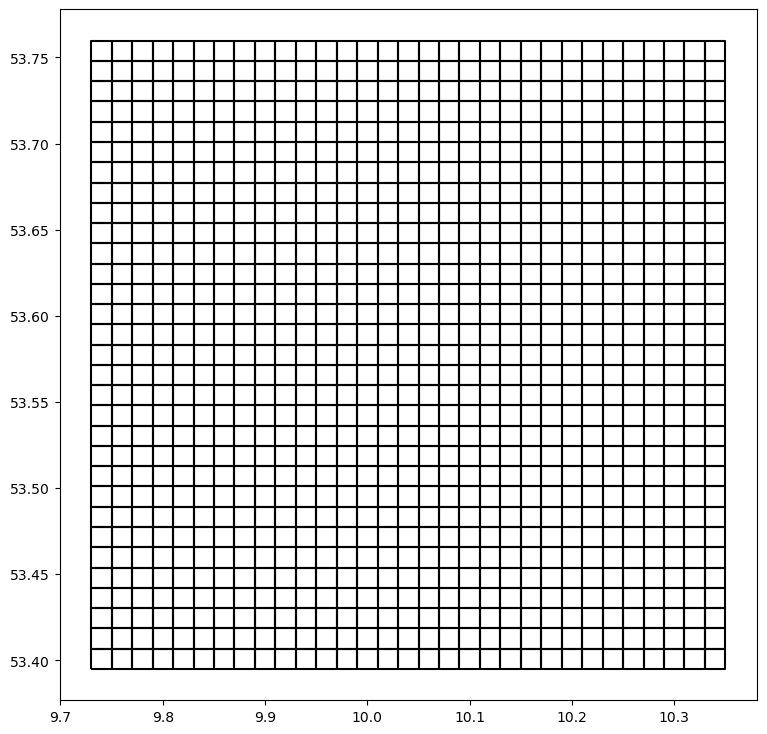

In [40]:
##  ---------- Visualization of grid ----------- ##


fig, ax = plt.subplots(figsize=(9, 9))
grid_gdf.boundary.plot(ax=ax, color='k')
plt.show()

In [41]:
##  ---------- Join Polygons and Grid ----------- ##


# Perform a spatial join between the grid and the polygons
# This example uses 'intersects' to join based on overlapping areas
joined_gdf = gpd.sjoin(grid_gdf, hamburg_shp, how='left', op='intersects')

# Now, 'joined_gdf' contains grid cells and the data from any polygons they intersect

aggregated_data = joined_gdf.groupby(joined_gdf.index).agg({'market_count': 'mean'})

# Join the aggregated data back to the grid GeoDataFrame
grid_gdf = grid_gdf.join(aggregated_data)



/Users/ferdinand/anaconda3/envs/geo_env/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


geometry  market_count
0    POLYGON ((9.73013 53.39501, 9.75013 53.39501, ...           NaN
1    POLYGON ((9.73013 53.40678, 9.75013 53.40678, ...           NaN
2    POLYGON ((9.73013 53.41854, 9.75013 53.41854, ...           NaN
3    POLYGON ((9.73013 53.43030, 9.75013 53.43030, ...           NaN
4    POLYGON ((9.73013 53.44207, 9.75013 53.44207, ...           NaN
..                                                 ...           ...
956  POLYGON ((10.33013 53.70089, 10.35013 53.70089...           NaN
957  POLYGON ((10.33013 53.71266, 10.35013 53.71266...           NaN
958  POLYGON ((10.33013 53.72442, 10.35013 53.72442...           NaN
959  POLYGON ((10.33013 53.73619, 10.35013 53.73619...           NaN
960  POLYGON ((10.33013 53.74795, 10.35013 53.74795...           NaN

[961 rows x 2 columns]

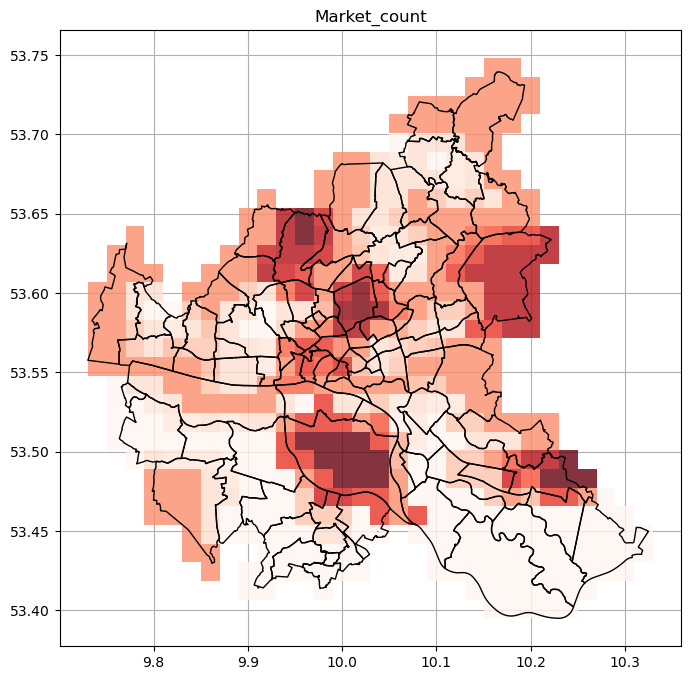

In [42]:
##  ---------- Visualization of Data on Grid ----------- ##

fig, ax = plt.subplots(figsize=(10, 8))
hamburg_shp.plot(ax=ax, color='none', edgecolor='black', zorder=3, categorical=True)
grid_gdf.plot(column='market_count', ax=ax, alpha=0.8, categorical=True, cmap='Reds', zorder=2)

ax.grid(True)
#Title
ax.set_title("Market_count")
#plt.savefig("gridvis_market_grid_small")
plt.show()


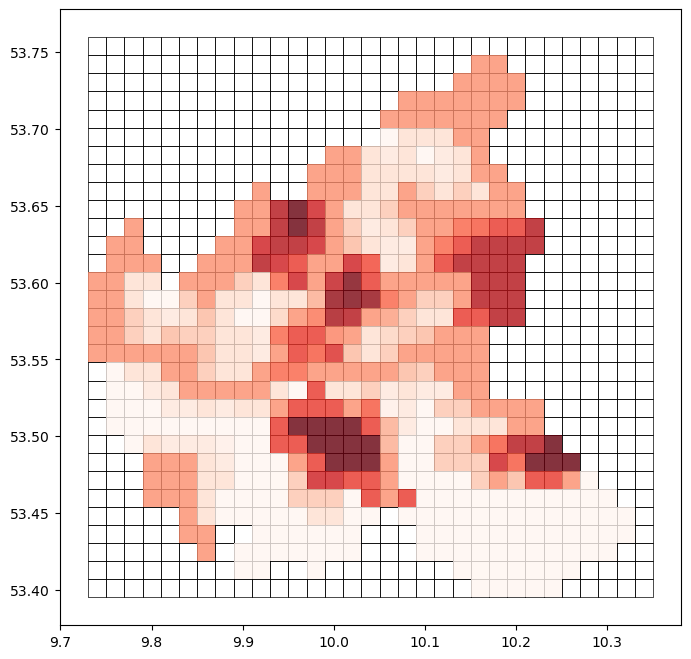

In [43]:
##  ---------- Visualization of Data on Grid ----------- ##


fig, ax = plt.subplots(figsize=(10, 8))

grid_gdf.boundary.plot(ax=ax, color='black', linewidth=0.5)
grid_gdf.plot(column='market_count',ax=ax, alpha=0.8, categorical=True, cmap='Reds', zorder=2)

plt.show()


## Getis Oerd - Hotspot Analysis


/var/folders/lj/q1ndb2493275c2y0vzyplnk00000gn/T/ipykernel_1807/4013279545.py:4: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(hamburg_shp)
/Users/ferdinand/anaconda3/envs/geo_env/lib/python3.12/site-packages/splot/_viz_libpysal_mpl.py:115: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_shp = gdf.centroid.values
/Users/ferdinand/anaconda3/envs/geo_env/lib/python3.12/site-packages/splot/_viz_libpysal_mpl.py:154: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.plot(ax=ax, **node_kws)


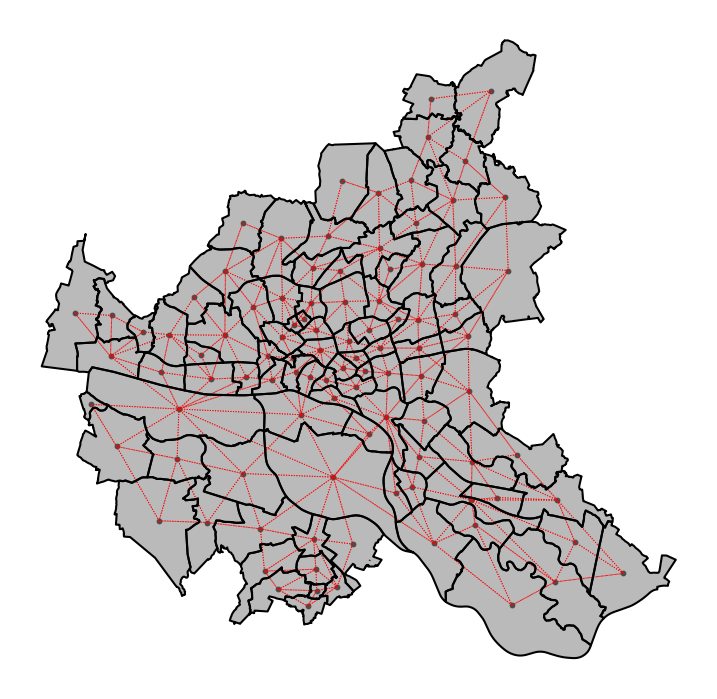

Number of observations: 99
Average number of neighbors: 5.2727272727272725


In [50]:
##  ---------- Queen contiguity  ----------- ##

# Create spatial weights using the Queen contiguity method from the GeoDataFrame - neighboring polygons
w = Queen.from_dataframe(hamburg_shp)

# Set up the plot
fig, ax = plt.subplots(figsize=(9, 9))

# Plot the spatial weights with custom edge styling
plot_spatial_weights(w, hamburg_shp, ax=ax, edge_kws=dict(color='r', linestyle=':', linewidth=1))

# Plot the boundaries of the Hamburg shapefile
hamburg_shp.boundary.plot(ax=ax, color='k')

# Display the plot
plt.show()

# Print the number of observations and average number of neighbors
print(f"Number of observations: {w.n}")
print(f"Average number of neighbors: {w.mean_neighbors}")


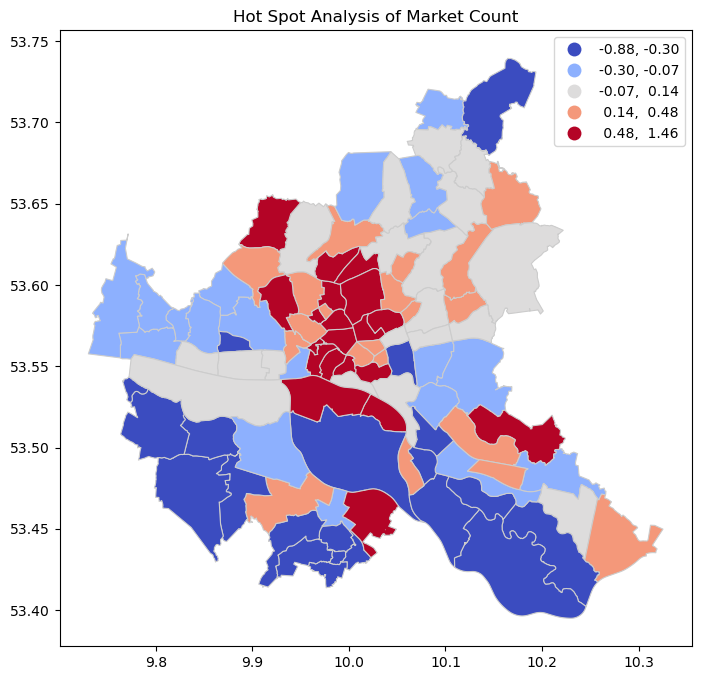

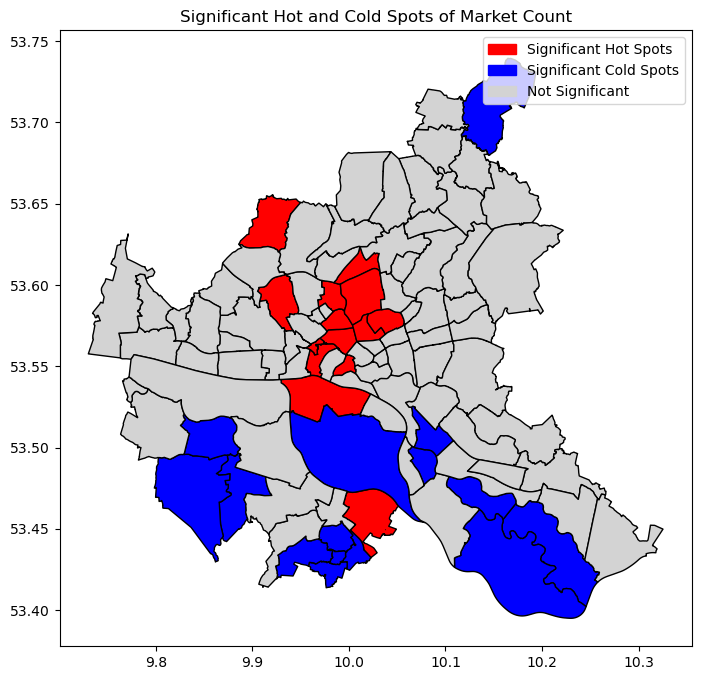

In [54]:
##  ---------- Hotspot Analysis  ----------- ##

# Perform Local G* statistic (Getis-Ord) for spatial autocorrelation analysis
g_stat = G_Local(hamburg_shp['market_count'], w)

# Add Z-scores and p-values to the GeoDataFrame
hamburg_shp["g_stat_z"] = g_stat.Zs
hamburg_shp['g_stat_p'] = g_stat.p_sim

# Define the significance level - 10% for this example
significance_level = 0.1

# Mark significant hot spots and cold spots
hamburg_shp['significant'] = ((hamburg_shp['g_stat_p'] < significance_level) & 
                              (hamburg_shp['g_stat_z'] > 0)).astype(int)  # 1 for significant hot spots
hamburg_shp['significant'] -= ((hamburg_shp['g_stat_p'] < significance_level) & 
                               (hamburg_shp['g_stat_z'] < 0)).astype(int)  # -1 for significant cold spots

# Create a plot for the Z-scores of the G* statistic
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the GeoDataFrame with the G* Z-scores
hamburg_shp.plot(column='g_stat_z', cmap='coolwarm', legend=True, 
                 scheme='quantiles', k=5, linewidth=0.8, ax=ax, 
                 edgecolor='0.8', label="Z-Score of G* Statistic")

# Set the title for the plot
ax.set_title('Hot Spot Analysis of Market Count')

# Display the plot
plt.show()

##  ---------- Significant Hot and Cold Spots  ----------- ##

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plot significant hot spots
hamburg_shp[hamburg_shp['significant'] == 1].plot(ax=ax, color='red', 
                                                  label='Significant Hot Spots', edgecolor='black')

# Plot significant cold spots
hamburg_shp[hamburg_shp['significant'] == -1].plot(ax=ax, color='blue', 
                                                   label='Significant Cold Spots', edgecolor='black')

# Optionally, plot nonsignificant areas differently
hamburg_shp[hamburg_shp['significant'] == 0].plot(ax=ax, color='lightgrey', 
                                                  label='Not Significant', edgecolor='black')

# Customize the plot
ax.set_title('Significant Hot and Cold Spots of Market Count')

# Create legend patches
red_patch = mpatches.Patch(color='red', label='Significant Hot Spots')
blue_patch = mpatches.Patch(color='blue', label='Significant Cold Spots')
grey_patch = mpatches.Patch(color='lightgrey', label='Not Significant')
plt.legend(handles=[red_patch, blue_patch, grey_patch])

# Display the plot
plt.show()
